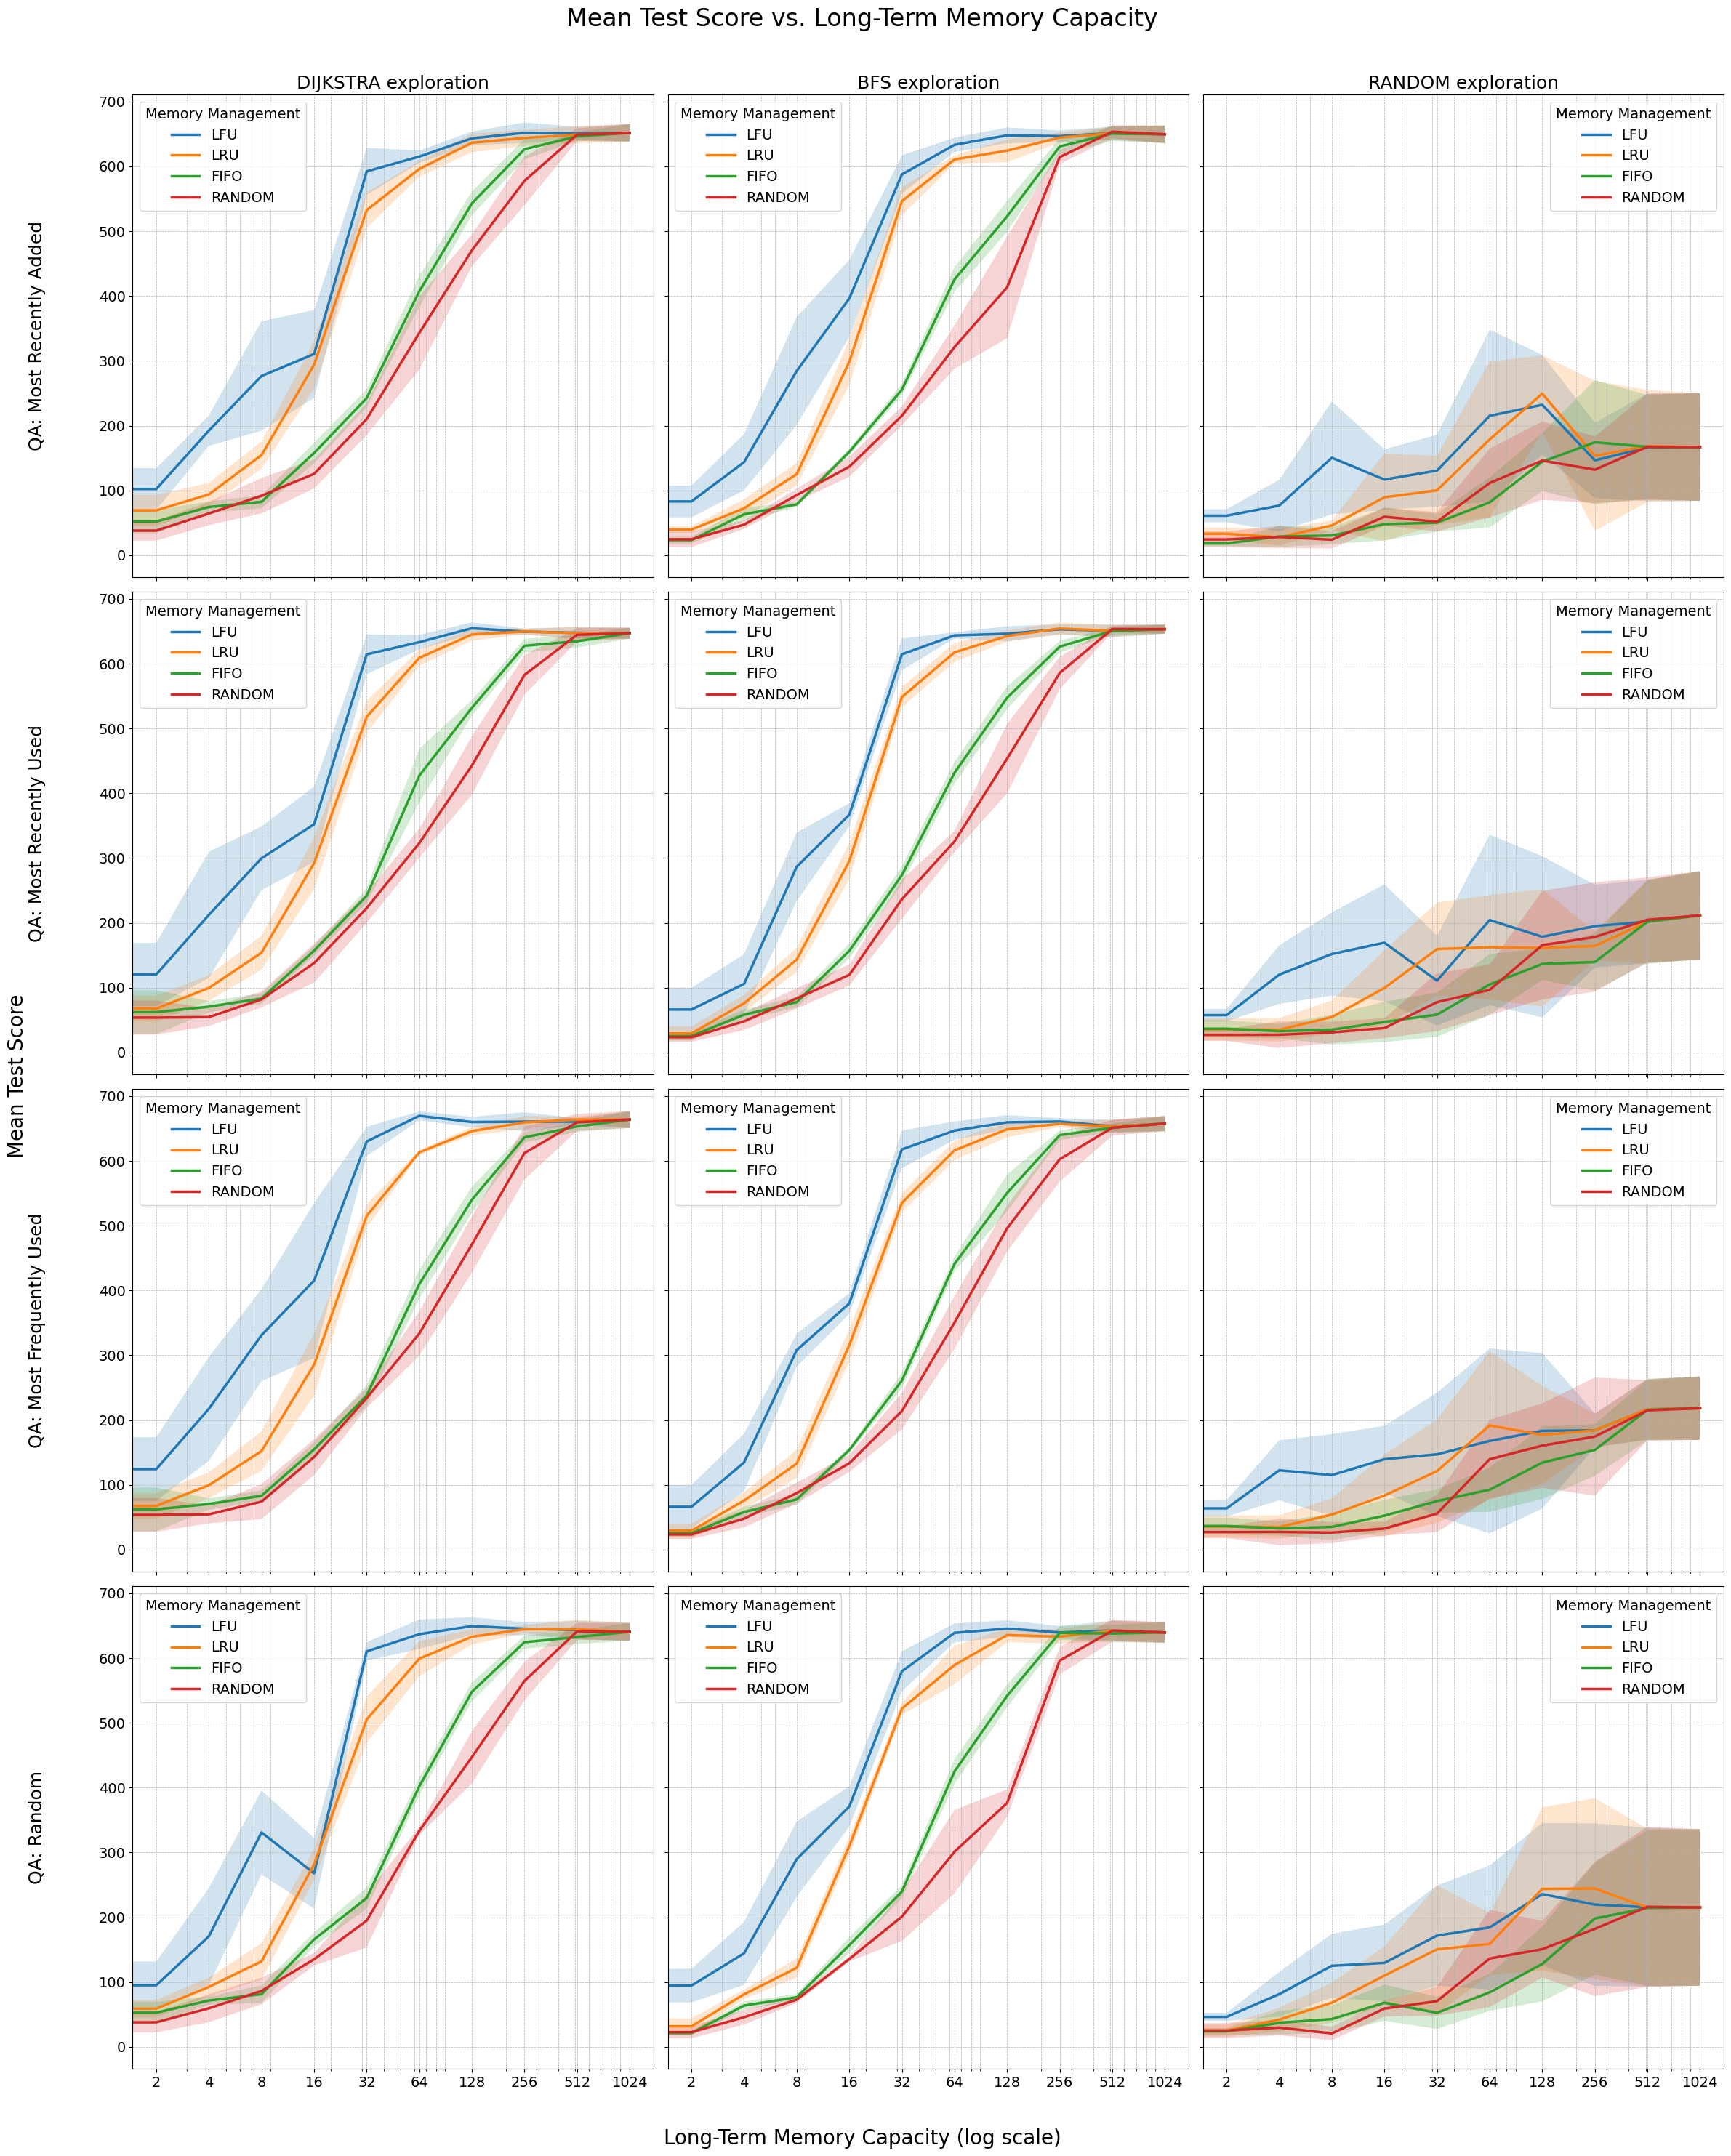

In [ ]:
import sys
import os

# Get the absolute path to the project root directory
root_path = os.path.abspath(os.path.join(os.getcwd(), '..'))

# Add the project root directory to the Python path
if root_path not in sys.path:
    sys.path.insert(0, root_path)

import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import json

# === CONFIGURATION ===
file_path = "../data/results_xl-different-prob.json"
include_shading = True   # Toggle shading for std deviation
log_xaxis = True
log_yaxis = False
line_width = 2.5
# ======================

# Load and prepare data
with open(file_path, "r") as f:
    data = json.load(f)

df = pd.DataFrame(data)
df = df.sort_values(by=["qa_policy", "explore_policy", "mm_long_policy", "memory_size"])

qa_policies = ["most_recently_added", "most_recently_used", "most_frequently_used", "random"]
explore_policies = ["dijkstra", "bfs", "random"]
mm_policies = ["lfu", "lru", "fifo", "random"]

# Create 4×3 subplot grid (4 QA policies × 3 exploration policies)
fig, axes = plt.subplots(4, 3, figsize=(24, 30), sharex=True, sharey=True)

for i, qa_policy in enumerate(qa_policies):
    for j, explore_policy in enumerate(explore_policies):
        ax = axes[i, j]
        for mm_long_policy in mm_policies:
            sub_df = df[
                (df["qa_policy"] == qa_policy)
                & (df["explore_policy"] == explore_policy)
                & (df["mm_long_policy"] == mm_long_policy)
            ]
            if len(sub_df) > 0:  # Check if data exists for this combination
                x = sub_df["memory_size"]
                y = sub_df["mean_score"]
                yerr = sub_df["std_score"]

                ax.plot(x, y, label=mm_long_policy.upper(), linewidth=line_width)
                if include_shading:
                    ax.fill_between(x, y - yerr, y + yerr, alpha=0.2)

        # Format only the first row and the first column for titles
        if i == 0:
            ax.set_title(f"{explore_policy.upper()} exploration", fontsize=18)
        if j == 0:
            ax.text(-0.2, 0.5, f"QA: {qa_policy.replace('_', ' ').title()}", 
                    rotation=90, transform=ax.transAxes, fontsize=18, 
                    verticalalignment='center')

        # Add legend to each subplot
        ax.legend(title="Memory Management", fontsize=14, title_fontsize=14, loc="best")
        ax.grid(True, which="both", linestyle="--", linewidth=0.5)
        ax.tick_params(axis="both", which="major", labelsize=14)

        if log_xaxis:
            ax.set_xscale("log")
            ax.set_xticks([2, 4, 8, 16, 32, 64, 128, 256, 512, 1024])
            ax.get_xaxis().set_major_formatter(ticker.ScalarFormatter())

        if log_yaxis:
            ax.set_yscale("log")
            ax.yaxis.set_major_locator(ticker.LogLocator(base=10.0, subs=None))
            ax.yaxis.set_minor_locator(ticker.NullLocator())
            ax.yaxis.set_major_formatter(ticker.ScalarFormatter())

# Shared axis labels
fig.text(
    0.5,
    0.01,
    "Long-Term Memory Capacity" + (" (log scale)" if log_xaxis else ""),
    ha="center",
    fontsize=20,
)
fig.text(
    0.01,
    0.5,
    "Mean Test Score" + (" (log scale)" if log_yaxis else ""),
    va="center",
    rotation="vertical",
    fontsize=20,
)
fig.suptitle("Mean Test Score vs. Long-Term Memory Capacity", fontsize=24, y=0.99)

plt.tight_layout(rect=[0.03, 0.03, 1, 0.98])
plt.savefig("../figures/agent_test_performance.pdf", bbox_inches="tight")
plt.savefig("../figures/agent_test_performance.png", bbox_inches="tight")
plt.show()